# Training

## Setup

In [18]:
import torch
import torchvision
from torchvision import datasets, transforms
import pandas as pd
from torch.utils.data import random_split 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
#from torch.autograd import Variable
from IPython.display import clear_output
import math


In [19]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')
#torch.backends.cudnn.enabled = False
val_size = 5000
test_size = 5000
batch_size = 64
num_workers = 4
pin_memory = False if device == torch.device('cpu') else True

# transform = transforms.Compose([transforms.ToTensor()])



# Normalize input images to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

reverse_transform = transforms.Compose([
    transforms.Lambda(lambda x: (x + 1) / 2),  # Reverse the normalization to get values in [0, 1]
    transforms.Lambda(lambda x: x.clamp(0, 1)),
    transforms.Lambda(lambda x: x.permute(1, 2, 0))
])


# Downloading MNIST again :) Training (60k) and test(5k) + val(5k) split
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./CIFAR_data',
                                            download=True,
                                            train=True,
                                            transform=transform),
                                            batch_size=batch_size,
                                            shuffle=True, num_workers=num_workers,
                                            pin_memory=pin_memory,
                                            drop_last=True)

test_dataset = datasets.CIFAR10('./CIFAR_data',
                               download=True,
                               train=False,
                               transform=transform)

val_dataset, test_dataset = random_split(test_dataset, [val_size, test_size])

# Test set to compare with DDPM paper
test_loader = torch.utils.data.DataLoader(test_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)

# Validation set so we can keep track of approximated FID score while training
validation_loader = torch.utils.data.DataLoader(val_dataset,
                                            batch_size=batch_size,
                                            shuffle=False, num_workers=num_workers,
                                            pin_memory=pin_memory)
    

Files already downloaded and verified
Files already downloaded and verified


In [21]:
def cosine_beta_schedule(T, s=0.008):
    steps = torch.linspace(0, T, T + 1, dtype=torch.float32)
    alpha_bar = torch.cos(((steps / T) + s) / (1 + s) * (math.pi / 2)) ** 2
    beta = 1 - (alpha_bar[1:] / alpha_bar[:-1])
    return beta.clamp(1e-5, 0.999)  # Avoid division by zero

T = 1000
beta = cosine_beta_schedule(T)
alpha = 1.0 - beta
alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# Reshape for broadcasting (if required for your model)
alpha = alpha.view((T, 1, 1, 1)).to(device)
beta = beta.view((T, 1, 1, 1)).to(device)
alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


In [ ]:
# # Linear noise schedule
# T = 1000
# beta_start, beta_end = 1e-4, 2e-2
# beta = torch.linspace(beta_start, beta_end, T)  # Linear noise schedule
# alpha = 1.0 - beta
# alpha_bar = torch.cumprod(alpha, dim=0)  # Cumulative product for alpha_bar

# # Reshape for broadcasting (if required for your model)
# alpha = alpha.view((T, 1, 1, 1)).to(device)
# beta = beta.view((T, 1, 1, 1)).to(device)
# alpha_bar = alpha_bar.view((T, 1, 1, 1)).to(device)


## Model

In [22]:
class LinearTimeEmbedding(nn.Module):
    def __init__(self, embedding_dim):
        super(LinearTimeEmbedding, self).__init__()
        self.projection = nn.Linear(1, embedding_dim)  # Project the scalar to the embedding dimension

    def forward(self, t):
        return self.projection(t.unsqueeze(-1))  # Add an extra dimension for the projection


In [23]:
class UNET(torch.nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        self.channels = [3,32, 64, 128, 256, 512]
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(self.channels[0], self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 32, 16, 16)
                nn.Conv2d(self.channels[1], self.channels[2], kernel_size=3, padding=1),  # (batchsize, 64, 16, 16)
                nn.GroupNorm(4, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 64, 7, 7)
                nn.Conv2d(self.channels[2], self.channels[3], kernel_size=3, padding=1),  # (batchsize, 128, 8, 8)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 128, 4, 4)
                nn.Conv2d(self.channels[3], self.channels[4], kernel_size=3, padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.MaxPool2d(2),  # (batchsize, 256, 2, 2)
                nn.Conv2d(self.channels[4], self.channels[5], kernel_size=3, padding=1),  # (batchsize, 512, 2, 2)
                nn.GroupNorm(8, self.channels[5]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            )
        ])

        self.tconvs = nn.ModuleList([
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[5], self.channels[4], kernel_size=3,
                                      stride=2, padding=1, output_padding=1),  # (batchsize, 256, 4, 4)
                nn.GroupNorm(8, self.channels[4]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[4]*2, self.channels[3], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 128, 8, 8)
                nn.GroupNorm(8, self.channels[3]),
                nn.ReLU(),
                nn.Dropout2d(0.2)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[3]*2, self.channels[2], kernel_size=3,
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 64, 16, 16)
                nn.GroupNorm(8, self.channels[2]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.ConvTranspose2d(self.channels[2]*2, self.channels[1], kernel_size=3, 
                                   stride=2, padding=1, output_padding=1),   # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1)
            ),
            nn.Sequential(
                nn.Conv2d(self.channels[1]*2, self.channels[1], kernel_size=3, padding=1),  # (batchsize, 32, 32, 32)
                nn.GroupNorm(4, self.channels[1]),
                nn.ReLU(),
                # nn.Dropout2d(0.1),
                nn.Conv2d(self.channels[1], self.channels[0], kernel_size=1)  # (batchsize, 3, 32, 32)
            )      
        ])
        
        self.time_layers = nn.ModuleList([
                nn.Linear(128, self.channels[i]) for i in range(len(self.channels))
        ])


    def forward(self, x, t_emb):
        signal = x
        signals = []
        for i, conv in enumerate(self.convs):
            # print(f"signal shape: {signal.shape}")
            t_emb_processed = self.time_layers[i](t_emb).view(-1, self.channels[i], 1, 1)
            signal= t_emb_processed+signal
            signal = conv(signal)
            if i < len(self.convs)-1:
                signals.append(signal)
        
        for i, tconv in enumerate(self.tconvs):
            # print(f"signal shape: {signal.shape}")
            # print(f"signals[-{i}] shape: {signals[-i].shape}")
            # print()
            t_emb_processed = self.time_layers[-(i + 1)](t_emb).view(-1, self.channels[-(i + 1)], 1, 1)
            signal= signal+t_emb_processed
            if i == 0:
                signal = tconv(signal)
            else:
                signal = torch.cat((signal, signals[-i]), dim=-3)
                signal = tconv(signal)

        return signal



## Training loop

In [ ]:
#from UNET import UNET
epochs = 200
model = UNET()
model.to(device)
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)
criterion = torch.nn.MSELoss(reduction='sum')

# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = LinearTimeEmbedding(time_embedding_dim).to(device)

In [ ]:
load_model = None
if load_model:
    model.load_state_dict(torch.load(load_model, map_location=device))

losses = []
batchlosses = []

# Training loop
for epoch in range(epochs):
    for e, data in enumerate(train_loader):
        x0, _ = data
        x0 = x0.to(device)
        t = torch.randint(0, T, (batch_size,), device=device)
        t_norm = t.float() / T
        t_emb = time_embedding_layer(t_norm)  # Shape: [batch_size, embedding_dim]
        eps = torch.randn_like(x0).to(device)
        x_t = torch.sqrt(alpha_bar[t]) * x0 + torch.sqrt(1 - alpha_bar[t]) * eps
        predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
        loss = criterion(predicted_eps, eps)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1)

        optimizer.step()

        losses.append(loss.item())


        # if e % 100 == 99:
        #     print(f"Epoch {epoch}, Batch {e+1}, Average Loss: {np.mean(losses[-100:]):.4f}")
    
    batchlosses.append(np.mean(losses[-100:]))
    print(f"Epoch {epoch}, Average Loss: {batchlosses[-1]:.4f}")
    plt.plot(batchlosses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()
    clear_output(wait=True)

    if epoch % 2 == 0 and epoch > 0:
        torch.save(model.state_dict(), f"data_CIFAR/DDPM_{epoch}.pth")




# Sampling

In [ ]:
load_model = None

if load_model:
    model.load_state_dict(torch.load(load_model, map_location=device))
with torch.inference_mode():
    model.eval()
    batch_size = 1
    xt = torch.randn(batch_size, 3, 32, 32).to(device)

    for t in torch.arange(T-1, 0-1, -1):
        t = t.reshape(1)
        t = t.to(device)
        t_emb = time_embedding_layer(t.float())
        z = torch.randn(batch_size, 3, 32, 32).to(device) if t > 0 else torch.zeros(batch_size, 3, 32, 32).to(device)
        
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t])/(torch.sqrt(1 - alpha_bar[t])) * 
                                                    model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        xt = xt_new

image = torch.permute(xt,(2,3,1,0))
image = image.reshape(32,32,3)
print(image.max())
print(image.min())
#weird clipping
plt.imshow(image)

# Overfit one batch

In [24]:
#from UNET import UNET

model = UNET().to(device)
# Initialize the linear time embedding layer
time_embedding_dim = 128  # You can set this to any suitable size
time_embedding_layer = LinearTimeEmbedding(time_embedding_dim).to(device)

# Get a single image from the batch
single_batch, _ = next(iter(train_loader))
single_batch = single_batch[0].unsqueeze(0).to(device)
single_batchs = single_batch.repeat(1, 1, 1, 1)
# Set the model to training mode
model.train()

# Define the optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4,weight_decay=1e-4)
criterion = torch.nn.MSELoss(reduction="sum")
plot_every = 400

running_loss = 0
# Training loop to overfit one batch
epochs = 5000
for epoch in range(epochs):
    t = torch.randint(0, T, (1,), device=device)
    t_norm = t.float() / T # Normalize the time to [0, 1]
    t_emb = time_embedding_layer(t_norm)  # Shape: [1, embedding_dim]
    eps = torch.randn_like(single_batchs).to(device)
    x_t = torch.sqrt(alpha_bar[t]) * single_batchs + torch.sqrt(1 - alpha_bar[t]) * eps
    predicted_eps = model(x_t, t_emb)  # Pass the precomputed embedding to the model
    loss = criterion(predicted_eps, eps)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    if epoch % 100 == 99:
        print(f"Epoch {epoch}, Average Loss: {running_loss / 100:.4f}")
        running_loss = 0.0  

    # if epoch % plot_every == 0:
    #     with torch.inference_mode():
    #         model.eval()
    #         t = torch.randint(0, T, (1,), device=device)
    #         t_emb = time_embedding_layer(t)
    #         eps = torch.randn_like(single_batch).to(device)
    #         x_t = torch.sqrt(alpha_bar[t]) * single_batch + torch.sqrt(1 - alpha_bar[t]) * eps
    #         predicted_eps = model(x_t, t_emb)
    #         reconstructed = x_t - predicted_eps
    #         fig, axs = plt.subplots(1, 3, tight_layout=True)
    #         axs[0].imshow(predicted_eps[0][0].cpu().detach().numpy(), cmap="gray")
    #         axs[0].set_title("Predicted Noise")
    #         axs[1].imshow(eps[0][0].cpu().detach().numpy(), cmap="gray")
    #         axs[1].set_title("True Noise")
    #         axs[2].imshow(np.abs(predicted_eps[0][0].cpu().detach().numpy()-eps[0][0].cpu().detach().numpy()), cmap="gray")
    #         axs[2].set_title("Difference in noise")
    #         plt.show()

Epoch 99, Average Loss: 2523.6421
Epoch 199, Average Loss: 947.8220
Epoch 299, Average Loss: 597.6556
Epoch 399, Average Loss: 432.1804
Epoch 499, Average Loss: 380.0208
Epoch 599, Average Loss: 312.8746
Epoch 699, Average Loss: 330.5510
Epoch 799, Average Loss: 401.0885
Epoch 899, Average Loss: 242.7378
Epoch 999, Average Loss: 235.3644
Epoch 1099, Average Loss: 230.7518
Epoch 1199, Average Loss: 196.7167
Epoch 1299, Average Loss: 214.6705
Epoch 1399, Average Loss: 217.0254
Epoch 1499, Average Loss: 245.4980
Epoch 1599, Average Loss: 175.8904
Epoch 1699, Average Loss: 239.5376
Epoch 1799, Average Loss: 162.8117
Epoch 1899, Average Loss: 223.8592
Epoch 1999, Average Loss: 209.0448
Epoch 2099, Average Loss: 153.2530
Epoch 2199, Average Loss: 147.9254
Epoch 2299, Average Loss: 158.1278
Epoch 2399, Average Loss: 127.8022
Epoch 2499, Average Loss: 157.0571
Epoch 2599, Average Loss: 172.7261
Epoch 2699, Average Loss: 129.1337
Epoch 2799, Average Loss: 133.0477
Epoch 2899, Average Loss: 163.

tensor(3.3508, device='cuda:0')
tensor(4.4147, device='cuda:0')
tensor(4.2902, device='cuda:0')
tensor(3.5620, device='cuda:0')
tensor(3.1804, device='cuda:0')
tensor(3.5739, device='cuda:0')
tensor(3.9571, device='cuda:0')
tensor(3.5804, device='cuda:0')
tensor(3.2405, device='cuda:0')
tensor(3.5855, device='cuda:0')
tensor(3.5274, device='cuda:0')
tensor(3.6603, device='cuda:0')
tensor(3.2513, device='cuda:0')
tensor(3.4889, device='cuda:0')
tensor(3.5672, device='cuda:0')
tensor(4.0265, device='cuda:0')
tensor(3.3061, device='cuda:0')
tensor(3.1895, device='cuda:0')
tensor(3.3869, device='cuda:0')
tensor(3.6908, device='cuda:0')
tensor(4.0777, device='cuda:0')
tensor(4.4354, device='cuda:0')
tensor(3.4369, device='cuda:0')
tensor(3.5321, device='cuda:0')
tensor(3.2118, device='cuda:0')
tensor(3.4540, device='cuda:0')
tensor(3.7779, device='cuda:0')
tensor(3.8507, device='cuda:0')
tensor(3.5781, device='cuda:0')
tensor(3.3307, device='cuda:0')
tensor(3.3555, device='cuda:0')
tensor(4

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(3.3665, device='cuda:0')
tensor(3.4034, device='cuda:0')
tensor(3.3086, device='cuda:0')
tensor(3.8752, device='cuda:0')
tensor(3.4100, device='cuda:0')
tensor(3.5390, device='cuda:0')
tensor(3.2035, device='cuda:0')
tensor(3.6376, device='cuda:0')
tensor(4.0502, device='cuda:0')
tensor(3.4633, device='cuda:0')
tensor(3.9895, device='cuda:0')
tensor(4.0918, device='cuda:0')
tensor(3.7971, device='cuda:0')
tensor(0., device='cuda:0')
-4447.294 5525.3887


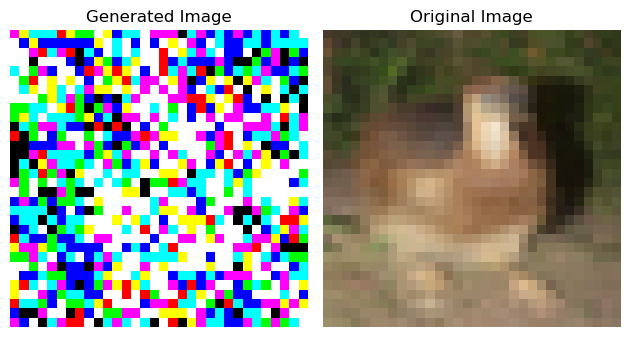

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize a random noise tensor
xt = torch.randn(1, 3, 32, 32).to(device)



# Perform the reverse diffusion process
with torch.no_grad():
    for t in torch.arange(T-1, -1, -1):
        t = t.reshape(1).to(device)
        t_norm = t.float() / T
        
        t_emb = time_embedding_layer(t_norm)

        z = torch.randn(1, 3, 32, 32).to(device) if t > 0 else torch.zeros(1, 3, 32, 32).to(device)
        
        # xt = xt.clamp(-1, 1)
        xt_new = 1 / torch.sqrt(alpha[t]) * (xt - (1 - alpha[t]) / torch.sqrt(1 - alpha_bar[t]) * model(xt, t_emb)) + torch.sqrt(beta[t]) * z
        
        xt = xt_new
        

im1 = xt[0]
im2 = single_batch[0]
im1 = (im1+1)/2
im1 = im1.permute(1, 2, 0)
im1 = im1.cpu().detach().numpy()


im2 = (im2+1)/2
im2 = im2.permute(1, 2, 0)
im2 = im2.cpu().detach().numpy()


print(im1.min(),im1.max())

fig,axs = plt.subplots(1, 2, tight_layout=True)
axs[0].imshow(im1)
axs[0].set_title("Generated Image")
axs[0].axis("off")
axs[1].imshow(im2)
axs[1].set_title("Original Image")
axs[1].axis("off")
plt.show()


# # Plot the generated image
# fig,axs = plt.subplots(1, 2, tight_layout=True)
# axs[0].imshow(reverse_transform(xt[0].cpu().detach()))
# axs[0].set_title("Generated Image")
# axs[0].axis("off")
# axs[1].imshow(reverse_transform(single_batch[0].cpu().detach()))
# axs[1].set_title("Original Image")
# axs[1].axis("off")
# plt.show()